In [1]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from src.data.naver_dataset import NAVERDataset
from src.losses import SegmentationLoss
from src.models import SegmentationModel
from src.utils.config import load_config
import torch

config = load_config('../configs/training/base_config.yml')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
print(config['data'])

{'dataset_path': 'data/processed', 'image_size': [256, 256], 'num_classes': 5, 'batch_size': 16, 'color_map': {0: [0, 0, 0], 1: [222, 31, 7], 2: [200, 200, 200], 3: [34, 97, 38], 4: [0, 69, 255]}}


In [3]:
print(config)

{'augmentation': {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}, 'data': {'dataset_path': 'data/processed', 'image_size': [256, 256], 'num_classes': 5, 'batch_size': 16, 'color_map': {0: [0, 0, 0], 1: [222, 31, 7], 2: [200, 200, 200], 3: [34, 97, 38], 4: [0, 69, 255]}}, 'model': {'name': 'unet', 'type': 'machine_learning', 'params': {'encoder_name': 'resnet34', 'encoder_weights': 'imagenet', 'in_channels': 3, 'classes': 5}}, 'loss': {'name': 'focal', 'params': {'mode': 'multiclass', 'alpha': 0.25, 'gamma': 2.0}}, 'optimizer': {'name': 'adam', 'learning_rate': 0.0001, 'params': None}, 'scheduler': {'name': 'reduce_on_plateau', 'params': {'mode': 'min', 'factor': 0.5, 'patience': 5}}, 'metrics': {'num_classes': 5, 'task': 'multiclass', 'average': 'macro'}, 'training': {'epochs': 5, 'model_checkpoint': 'checkpoints/unet.pth'}}


In [4]:
train_dataset = NAVERDataset(config, split='train')
val_dataset = NAVERDataset(config, split='val')
test_dataset = NAVERDataset(config, split='test')

In [5]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

2629
328
330


Ortho_Row(241)_Col(318)_resample_patch_3_6.tif


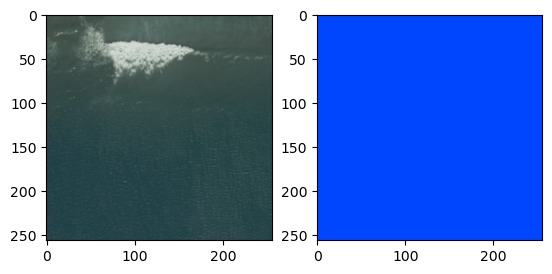

In [6]:
from src.utils.visualize import mask_to_color_image
import random
from src.data.preprocessing.transforms import UnNormalize

color_map = config['data']['color_map']
random_index = random.randint(0, 1000)
unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

data = train_dataset.__getitem__(random_index)
image = data['image']
mask = data['mask']
print(data['image_name'])
plt.subplot(1, 2, 1)
plt.imshow(unorm(image).permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(mask_to_color_image(mask, color_map))
plt.show()

In [7]:
BATCH_SIZE = config['data']['batch_size']
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
model = SegmentationModel.get_model(config['model']['name'], **config['model'].get('params', {})).to(device)

In [9]:
loss_fn = SegmentationLoss.get_loss(config['loss']['name'], **config['loss'].get('params', {}))

In [10]:
from src.utils.metric import AverageMeter
from src.trainers import Trainer

metric_meters = {
    'train_loss': AverageMeter(), 'train_dice': AverageMeter(),
    'train_iou': AverageMeter(), 'train_acc': AverageMeter(),
    'val_loss': AverageMeter(), 'val_dice': AverageMeter(),
    'val_iou': AverageMeter(), 'val_acc': AverageMeter()
}

trainer = Trainer(
        model=model,
        loss_fn=loss_fn,
        config=config,
        metric_meters=metric_meters,
        train_loader=train_loader,
        val_loader=val_loader,
)

trainer.train()

Training:   2%|▏         | 4/165 [00:03<02:22,  1.13it/s]


KeyboardInterrupt: 